In [1]:
save_path = "/Users/maori2/SchoenbaumLab Dropbox/ido maor/Mac/Documents/Lab/data/behavior/Saved_analysis"


import scipy.io as sio
import scipy.stats as sts
import numpy as np
import pandas as pd
import os
import psytrack as psy
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import pickle
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.spatial.distance import mahalanobis as mahal
from scipy.spatial.distance import seuclidean, canberra, euclidean, cosine, minkowski
from scipy.linalg import pinvh

from matplotlib.gridspec import GridSpec
import statsmodels.api as sm

import scipy.io
from zetapy import ifr, zetatest, zetatstest, zetatest2, zetatstest2, plotzeta, plottszeta, plotzeta2, plottszeta2
from scipy.stats import norm
from scipy.signal import convolve
import time
from scipy.stats import ttest_ind

from sklearn import svm
from sklearn.model_selection import cross_val_predict, cross_val_score, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import sem
from sklearn import set_config
from sklearn.model_selection import permutation_test_score

from sklearn.linear_model import LinearRegression

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

plt.rcParams['axes.grid'] = False        # Disable grid lines globally
plt.rcParams['axes.linewidth'] = 1    # Make axes thicker
plt.rcParams['axes.edgecolor'] = 'black' # Make axes darker

In [12]:
def analyze_behave(Analysis_table):

    Analysis_table_f = Analysis_table[(Analysis_table.correction_trial==0) & (Analysis_table.odor_unpoke_early==0)].reset_index()
    max_unpoke = 5000 #trim the sampling odor windo to 5 sec
    Analysis_table_f.loc[Analysis_table_f.odor_unpoke-Analysis_table_f.odor_poke>max_unpoke,'odor_unpoke']=Analysis_table_f.odor_poke+max_unpoke
    Analysis_table_f.loc[:,'pre_trial'] = Analysis_table_f['light_on'] - 1000

    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    correct_cdnm = (np.average(HitRate_cdnm)+(1-np.average(FaRate_cdnm)))/2
    correct_disc = (np.average(HitRate_disc)+(1-np.average(FaRate_disc)))/2

    def calculate_d_prime(hits, false_alarms):
        if hits == 0:
            hits = 0.01
        if false_alarms == 0:
            false_alarms = 0.01
        if hits == 1:
            hits = 1 - 0.01
        if false_alarms == 1:
            false_alarms = 1 - 0.01


        hits = np.array(hits)
        false_alarms = np.array(false_alarms)

        # z-scores
        hitZ = sts.norm.ppf(hits)
        faZ  = sts.norm.ppf(false_alarms)

        # d-prime
        dPrime = hitZ-faZ

        return dPrime

    def find_first_index(Analysis_table_f): # Custom function to find the first index in vehave_crit where Value = 1
        index = (Analysis_table_f['behave_crit'] == 1).idxmax()
        return index if not (index==0 or pd.isna(index)) else 500

    dPrime_cdnm = calculate_d_prime(np.average(HitRate_cdnm), np.average(FaRate_cdnm))
    dPrime_disc = calculate_d_prime(np.average(HitRate_disc), np.average(FaRate_disc))
    tr_to_crit = index

    Analysis_table_mod = Analysis_table_f.copy()

    Analysis_table_mod.loc[:,'cdnm_rule']=cdnm_rule
    Analysis_table_mod.loc[:,'disc_rule']=disc_rule
    Analysis_table_mod.loc[:,'time_to_poke']=Analysis_table_f['odor_poke']-Analysis_table_f['light_on']
    Analysis_table_mod.loc[:,'time_to_unpoke']=Analysis_table_f['odor_unpoke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'time_to_water']=Analysis_table_f['water_poke']-Analysis_table_f['odor_poke']
    Analysis_table_mod.loc[:,'ITI']=Analysis_table_mod['light_on'].diff()
    Analysis_table_mod.loc[:,'odor_before']=s1[:,1]
    Analysis_table_mod.loc[0,'odor_before']=Analysis_table_mod.loc[1,'odor_before'] #puting the same odor on the first trial to avoide nans


    behave_dict = {
        "Analysis_table_mod":Analysis_table_mod,
        "correct_cdnm": correct_cdnm,
        "correct_disc": correct_disc,
        "dPrime_cdnm": dPrime_cdnm,
        "dPrime_disc": dPrime_disc,
        "tr_to_crit": tr_to_crit,
        "HitRate_cdnm": HitRate_cdnm,
        "FaRate_cdnm": FaRate_cdnm,
        "HitRate_disc":HitRate_disc,
        "FaRate_disc": FaRate_disc
    }
    return behave_dict

def calculate_d_prime(hits, false_alarms):
    if hits == 0:
        hits = 0.01
    if false_alarms == 0:
        false_alarms = 0.01
    if hits == 1:
        hits = 1 - 0.01
    if false_alarms == 1:
        false_alarms = 1 - 0.01


    hits = np.array(hits)
    false_alarms = np.array(false_alarms)

    # z-scores
    hitZ = sts.norm.ppf(hits)
    faZ  = sts.norm.ppf(false_alarms)

    # d-prime
    dPrime = hitZ-faZ

    return dPrime

def bin_performance(Analysis_table_f,  bin_num=4):
    y = np.array(Analysis_table_f.go_nogo)
    s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

    cdnm_only = (cdnm_rule==1) & (disc_rule==0)
    disc_only = (cdnm_rule==0) & (disc_rule==1)

    HitRate_cdnm = (y[cdnm_rule==1].astype(bool)==1)
    FaRate_cdnm = (y[cdnm_rule==0].astype(bool)==1)
    HitRate_disc =(y[disc_rule==1].astype(bool)==1)
    FaRate_disc = (y[disc_rule==0].astype(bool)==1)

    HitRate_cdnm_only = (y[cdnm_only==1].astype(bool)==1)
    FaRate_cdnm_only =  (y[cdnm_only==0].astype(bool)==1)
    HitRate_disc_only = (y[disc_only==1].astype(bool)==1)
    FaRate_disc_only = (y[disc_only==0].astype(bool)==1)

    correct_cdnm_bin =[]
    correct_disc_bin = []
    dPrime_cdnm_bin =[]
    dPrime_disc_bin = []
    HitRate_cdnm_bin =[]
    FARate_cdnm_bin = []
    HitRate_disc_bin =[]
    FARate_disc_bin = []
    correct_cdnm_only_bin =[]
    correct_disc_only_bin = []

    hist, bin_edges_1 = np.histogram(np.arange(0, len(HitRate_cdnm)), bins=bin_num); bined_day_1 = np.floor(bin_edges_1).astype(int)
    hist, bin_edges_2 = np.histogram(np.arange(0, len(FaRate_cdnm)), bins=bin_num); bined_day_2 = np.floor(bin_edges_2).astype(int)
    hist, bin_edges_3 = np.histogram(np.arange(0, len(HitRate_disc)), bins=bin_num); bined_day_3 = np.floor(bin_edges_3).astype(int)
    hist, bin_edges_4 = np.histogram(np.arange(0, len(FaRate_disc)), bins=bin_num); bined_day_4 = np.floor(bin_edges_4).astype(int)

    hist, bin_edges_5 = np.histogram(np.arange(0, len(HitRate_cdnm_only)), bins=bin_num); bined_day_5 = np.floor(bin_edges_5).astype(int)
    hist, bin_edges_6 = np.histogram(np.arange(0, len(FaRate_cdnm_only)), bins=bin_num); bined_day_6 = np.floor(bin_edges_6).astype(int)
    hist, bin_edges_7 = np.histogram(np.arange(0, len(HitRate_disc_only)), bins=bin_num); bined_day_7 = np.floor(bin_edges_7).astype(int)
    hist, bin_edges_8 = np.histogram(np.arange(0, len(FaRate_disc_only)), bins=bin_num); bined_day_8 = np.floor(bin_edges_8).astype(int)

    for ii in range(len(bined_day_1) - 1):

        #correct_cdnm_bin.append(np.average(raw_correct_cdnm_rule[start_index1:end_index1]))
        #correct_disc_bin.append(np.average(raw_correct_disc_rule[start_index1:end_index1]))
        correct_cdnm_bin.append((np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]])+(1-np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))/2)
        correct_disc_bin.append((np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]])+(1-np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))/2)

        dPrime_cdnm_bin.append(calculate_d_prime(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]), np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]])))
        dPrime_disc_bin.append(calculate_d_prime(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]), np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]])))

        HitRate_cdnm_bin.append(np.average(HitRate_cdnm[bined_day_1[ii]:bined_day_1[ii+1]]))
        FARate_cdnm_bin.append(np.average(FaRate_cdnm[bined_day_2[ii]:bined_day_2[ii+1]]))
        HitRate_disc_bin.append(np.average(HitRate_disc[bined_day_3[ii]:bined_day_3[ii+1]]))
        FARate_disc_bin.append(np.average(FaRate_disc[bined_day_4[ii]:bined_day_4[ii+1]]))

        correct_cdnm_only_bin.append((np.average(HitRate_cdnm_only[bined_day_5[ii]:bined_day_5[ii+1]])+(1-np.average(FaRate_cdnm_only[bined_day_6[ii]:bined_day_6[ii+1]])))/2)
        correct_disc_only_bin.append((np.average(HitRate_disc_only[bined_day_7[ii]:bined_day_7[ii+1]])+(1-np.average(FaRate_disc_only[bined_day_8[ii]:bined_day_8[ii+1]])))/2)

    return correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin
def running_average_crossing_threshold(Table, Win, T, X):
    # Create logical variable 'A' where 'B' is 'Hit' or 'CR'
    Table['A'] = ((Table['score'] == 'Hit') | (Table['score'] == 'CR')).astype(int)

    # Calculate the running average of the column 'A' with a window size 'Win'
    Table['Running_Avg'] = Table['A'].rolling(window=Win).mean()

    # Determine when the running average crosses the threshold 'T'
    Table['Crossed_Threshold'] = (Table['Running_Avg'] > T).astype(int)

    # Find consecutive crossings of length X
    Table['Consecutive_Crossings'] = Table['Crossed_Threshold'].rolling(window=X).sum()

    # Determine where exactly the threshold is reached in X consecutive rows
    #crossing_points = (Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)
    crossing_points = Table[(Table['Consecutive_Crossings'] >= X) & (Table['Crossed_Threshold'] == 1)]

    # Find the first index where the condition is met
    first_crossing_index = crossing_points.index[0] if not crossing_points.empty else None


    return Table, first_crossing_index
#correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=10)
def divide_intervals(start_times, end_times, num_intervals):
    # Check if the input arrays have the same length
    if len(start_times) != len(end_times):
        raise ValueError("Input arrays must have the same length")

    # Calculate the duration of each interval
    interval_durations = (end_times - start_times) / num_intervals

    # Create a list to store the divided intervals
    divided_intervals = []

    # Iterate through each start and end time pair
    for start, end in zip(start_times, end_times):
        # Calculate the boundaries of each subinterval
        subinterval_boundaries = np.linspace(start, end, num_intervals + 1)

        divided_intervals.append(subinterval_boundaries)

    return divided_intervals

def calc_PETH_equal_bins (Analysis_table, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5):
    start_times = np.array(Analysis_table[event_start])/1000
    end_times = np.array(Analysis_table[event_end])/1000

    time_intervals = divide_intervals(start_times, end_times, bin_num)
    ntrials=len(time_intervals)
    temp1=[]
    for (trial_idx, trial) in enumerate(time_intervals):
        binduration=np.round(np.diff(trial)[0],decimals=2)
        temp2=[]
        for (unit_idx, spikes_unit) in enumerate(spikeTime):
            spikeinds = spikes_unit[np.logical_and((spikes_unit >= trial[0]),(spikes_unit < trial[-1]))]
            spikes_bin =np.histogram(spikeinds,bins = trial)
            temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            #temp2.append(spikes_bin[0])
        temp1.append(np.array(temp2))
    spikes_all = np.array(temp1) # [Trials,units,bins]
    PETH = spikes_all.reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()


    return PETH, Trials, spikes_all


def calc_PETH(Analysis_table, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;
    temp=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                temp2.append((1/binduration)*spikes_bin[0])# moving to Hz - 08/15/2024
            temp1.append(np.array(temp2))
        temp.append(np.array(temp1))
    spikes_all = np.array(temp)
    #PETH = spikes_all.reshape((ntrials,-1))
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))

    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    #Analysis_table['vals_and_ID']=Analysis_table['odor_ID']+(cdnm_rule-1)*-100
    Analysis_table.loc[:, 'vals_and_ID'] = Analysis_table['odor_ID'].copy() + (cdnm_rule.copy()-1)*-100

    #Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID"]].copy()
    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]].copy()

    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan).copy()

    return PETH, Trials, spikes_all

def calc_responsivness(Analysis_table_f,spikeTime):
    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime,events = ['odor_unpoke'] , resp_win = (-.5, 0)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all = np.squeeze(spikes_all)
    T_statistic_cdnm=[];P_value_cdnm=[];T_statistic_disc=[];P_value_disc=[];T_statistic_resp=[];P_value_resp=[]
    cell_num = spikes_all.shape[1]
    FR = np.mean(spikes_all,axis=2)
    trials_idx = Analysis_table_f.cdnm_rule == True; FR_cdnm_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.cdnm_rule == False; FR_cdnm_nogo = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == True; FR_disc_go = FR[trials_idx,:]
    trials_idx = Analysis_table_f.disc_rule == False; FR_disc_nogo = FR[trials_idx,:]
    PETH, Trials, spikes_all_spont = calc_PETH(Analysis_table_f, spikeTime,events = ['light_on'] , resp_win = (-1, -.5)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_spont = np.squeeze(spikes_all_spont)
    FR_spont = np.mean(spikes_all_spont,axis=2)

    for i in range(cell_num):
        t_statistic, p_value = ttest_ind(FR_cdnm_go[:,i], FR_cdnm_nogo[:,i])
        T_statistic_cdnm.append(t_statistic); P_value_cdnm.append(p_value)
        t_statistic, p_value = ttest_ind(FR_disc_go[:,i], FR_disc_nogo[:,i])
        T_statistic_disc.append(t_statistic); P_value_disc.append(p_value)
        t_statistic, p_value = ttest_rel(FR[:,i], FR_spont[:,i])
        T_statistic_resp.append(t_statistic); P_value_resp.append(p_value)


    responsiveness = pd.DataFrame({'FR_all':np.mean(FR[:,:],axis=0),'FR_spont':np.mean(FR_spont[:,:],axis=0),'FR_spont_std':np.std(FR_spont[:,:],axis=0),'FR_cdnm_go':np.mean(FR_cdnm_go,axis=0),'FR_cdnm_nogo':np.mean(FR_cdnm_nogo,axis=0),'FR_disc_go':np.mean(FR_disc_go,axis=0),'FR_disc_nogo':np.mean(FR_disc_nogo,axis=0),
                                   'T_statistic_cdnm':np.array(T_statistic_cdnm),'P_value_cdnm':np.array(P_value_cdnm),'T_statistic_disc':np.array(T_statistic_disc),'P_value_disc':np.array(P_value_disc),'T_statistic_resp':np.array(T_statistic_resp),'P_value_resp':np.array(P_value_resp)})
    return responsiveness

# 2)Dimensionality reduction

def runPCA(PETH,n_components=50):
    X = PETH[:,:]
    pca = PCA(n_components=n_components)
    H = pca.fit(X)  # Reconstruct signals based on orthogonal components
    Y = H.components_
    Y.shape # Y: NXT
    V_pca = pca.fit_transform(X)
    V_pca.shape #V:MXN (the Eigenvectors)
    exp_var = pca.explained_variance_ratio_

    return V_pca, exp_var

def run_Similarity(V_pca,Trials):

    from scipy.spatial.distance import cosine
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],V_pca.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(V_pca[Trials["vals_and_ID"]==val,:],0)
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return  av_LDA, cm

def run_LDA(B,Trials):

    clf = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)
    LDA_transformed = clf.fit(B, Trials["vals_and_ID"])
    # !!!!!!!!!!!!!!!
    LDA_coef = LDA_transformed.coef_ #
    B_LDA = np.dot( B,LDA_coef.transpose())
    #!!!!!!!!!!!!!!!
    B_LDA.shape # MXN
    LDA_exp_var = LDA_transformed.explained_variance_ratio_
    u_vals = np.sort(pd.unique(Trials["vals_and_ID"]))
    av_LDA = np.empty([u_vals.shape[0],B_LDA.shape[1]])
    for val_id, val in enumerate(u_vals):
        av_LDA [val_id,:] = np.mean(B_LDA[Trials["vals_and_ID"]==val,:],0)
    #av_LDA = av_LDA
    cm = np.zeros([av_LDA.shape[0],av_LDA.shape[0]])
    c_m = np.cov(av_LDA, rowvar=False)
    #C_inv = np.linalg.inv(c_m)
    var_i = np.var(B_LDA,axis = 0)

    for i, LDA_i in enumerate(av_LDA):
        for j, LDA_j in enumerate(av_LDA):
            cov = np.cov(LDA_i,LDA_j)
            #C_inv = np.linalg.inv(cov)
            #cm[i,j] = mahal(LDA_i, LDA_j, C_inv)
            #cm[i,j] = euclidean(LDA_i, LDA_j)
            cm[i,j] =  cosine(LDA_i, LDA_j)

    return B_LDA, av_LDA, cm, LDA_exp_var, LDA_transformed, LDA_coef

def calc_PETH_with_baseline(Analysis_table, spikeTime, events = ['odor_unpoke'],resp_win = (-2, 2), binduration = .05):

    nbins = int((resp_win[1]-resp_win[0])/binduration)
    timebins=np.arange(resp_win[0],(resp_win[1]+binduration),binduration,dtype=float)
    nunits=spikeTime.size;

    basline_time = np.array(Analysis_table['light_on'] - 1000)/1000 #moving to sec   


    temp=[]
    base=[]
    for (event_idx, event) in enumerate(events):
        stim_times = np.array(Analysis_table[event])
        stimulustimes = stim_times/1000; #moving to sec                
        ntrials=stimulustimes.size;
        temp1=[]
        base1=[]
        for  (trial_idx, trial) in enumerate(stimulustimes):
            temp2=[]
            base2=[]
            for (unit_idx, spikes_unit) in enumerate(spikeTime):
                spikeinds = spikes_unit[np.logical_and((spikes_unit >= (trial+resp_win[0])),(spikes_unit < (trial+resp_win[1])))]-trial
                spikeinds_baseline = spikes_unit[np.logical_and((spikes_unit >= basline_time[trial_idx]),(spikes_unit < (basline_time[trial_idx]+.5)))]-basline_time[trial_idx]
                baseline_fr = len(spikeinds_baseline)*2 #moving to Hz
                spikes_bin =np.histogram(spikeinds,bins = timebins)
                #temp2.append((1/binduration)*spikes_bin[0] - baseline_fr) # moving to Hz and substracting basline
                temp2.append((1/binduration)*spikes_bin[0]) # moving to Hz
                base2.append(baseline_fr)
            temp1.append(np.array(temp2))
            base1.append(np.array(base2))
        temp.append(np.array(temp1))
        base.append(np.array(base1))
    spikes_all = np.array(temp)
    baseline_all = np.array(base)
    PETH = np.swapaxes(spikes_all, 0, 1).reshape((ntrials,-1))


    s1 = np.column_stack((Analysis_table.odor_ID,Analysis_table.odor_ID.shift(1,fill_value=np.nan),Analysis_table.odor_ID.shift(2,fill_value=np.nan)))
    cdnm_rule = s1[:,0]!=s1[:,1]
    Analysis_table.loc[:,'vals_and_ID']=Analysis_table.loc[:,'odor_ID']+(cdnm_rule-1)*-100


    Trials = Analysis_table[["odor_ID","odor_value","go_nogo","score","vals_and_ID","cdnm_rule","disc_rule"]]
    Trials.loc[:,'odor_before'] = Analysis_table.odor_ID.shift(1,fill_value=np.nan)

    return PETH, Trials, spikes_all,baseline_all

def calc_zScore (spikes_all,baseline_all,trials_idx):
    baseline_mean = np.mean(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std = np.std(np.squeeze(baseline_all)[trials_idx,:],0)
    baseline_std[baseline_std==0] = 1 #to overcome dividing by zero
    nbins = spikes_all.shape[3]
    temp = baseline_mean[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_mean = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    temp = baseline_std[:, np.newaxis]# Add a new axis using np.newaxis
    replicated_baseline_std = np.tile(temp, (1, nbins))# Replicate the vector along the new axis using np.tile
    mean_fr = np.mean(np.squeeze(spikes_all[:,trials_idx,:,:]),0)
    z_score = (mean_fr - replicated_baseline_mean)/replicated_baseline_std

    return z_score


def prep_for_svm(Analysis_table_f,spikeTime):


    PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    # PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    # [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)     # Concatenate along the x-axis (columns)

    PETH, Trials, spikes_all_before = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 3 time points)
    PETH, Trials, spikes_all_response = calc_PETH(Analysis_table_f, spikeTime , events = ['odor_unpoke'] , resp_win = (0, .3)) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    spikes_all_concat = np.concatenate((np.squeeze(spikes_all_before),np.squeeze(spikes_all),np.squeeze(spikes_all_response)),axis=2)

    newDF_bins=[]
    for i in range(spikes_all_concat.shape[2]): #run over differnt bins
        PETH = np.squeeze(spikes_all_concat[:,:,i]) # select a specific bin
        df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
        newDF_bins.append( pd.concat([df1_reset, newDF_temp], axis=1))

    return newDF, newDF_bins

def prep_for_svm_pca(Analysis_table_f,spikeTime):


    #     PETH, Trials, spikes_all = calc_PETH_equal_bins (Analysis_table_f, spikeTime , event_start = 'odor_poke' , event_end = 'odor_unpoke' , bin_num = 5)
    #     PETH = np.squeeze(spikes_all.mean(axis = 2)) # mean over all bins

    PETH, Trials, spikes_all = calc_PETH(Analysis_table_f, spikeTime , events = ['light_on','odor_poke','odor_time','odor_unpoke'] , resp_win = (-.2, .4),binduration=.1) #Trials by events X bins X units (number of neurons × 4 epochs × 8 time points)
    [PETH, temp] = runPCA(PETH)

    newDF_temp = Analysis_table_f.loc[:,["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"]]

    df1_reset = pd.DataFrame(PETH).reset_index(drop=True)
    # Concatenate along the x-axis (columns)
    newDF = pd.concat([df1_reset, newDF_temp], axis=1)

    return newDF



def calc_svm(newDF,decode_var = 'cdnm_rule',reg_var = 'go_nogo'):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(newDF[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, newDF[newDF[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())

    cm = confusion_matrix(y, y_pred,normalize='true')
    # score_m = cross_val_score(clf, X, y, cv=LeaveOneOut()).mean()
    # score_s = cross_val_score(clf, X, y, cv=LeaveOneOut()).std()

    score_m = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)
    score_s = np.round(cross_val_score(clf, X, y, cv=LeaveOneOut(),scoring='accuracy').std(),2)


    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1)

    X_residuals = regress_out_variable(X, df[reg_var])
    score_reg = np.round(cross_val_score(clf, X_residuals, y, cv=LeaveOneOut(),scoring='accuracy').mean(),2)

    return cm,min_reps,score_m,score_s,D_df,score_reg

def calc_svm_with_permutation(df_forSVM,decode_var = 'cdnm_rule',n_permutations=1000):

    #dilute the dataframe so number of trial repetiations will be equal to the min number
    class_IDs, counts = np.unique(df_forSVM[decode_var],return_counts=True)
    min_reps = np.min(counts)
    df = pd.DataFrame()
    for class_ID in class_IDs:
        df = pd.concat([df, df_forSVM[df_forSVM[decode_var] == class_ID].tail(min_reps)])

    #seperate the dataset into response variable and feature variables:

    X = df.drop(["odor_ID","odor_value","go_nogo","score","cdnm_rule","disc_rule","vals_and_ID","odor_before"],axis=1)
    y = df[decode_var]

    # SVM Classifier
    clf = make_pipeline(StandardScaler(), svm.SVC())

    # Perform permutation test
    score, permutation_scores, p_value = permutation_test_score(
        clf, X, y, scoring="accuracy", n_permutations=n_permutations, random_state=42)

    y_pred = cross_val_predict(clf, X, np.ravel(y), cv=LeaveOneOut())
    D_df = pd.concat((df.reset_index(),pd.DataFrame(y_pred,columns=['y_pred'])),axis=1) #data frame with trials info and predictions    
    cm = confusion_matrix(y, y_pred,normalize='true')

    return score,permutation_scores,p_value,D_df,cm

def regress_out_variable(X, variable):
    if isinstance(variable, pd.Series):
        variable = variable.to_numpy().reshape(-1, 1)
    else:
        variable = np.array(variable).reshape(-1, 1)

    regressor = LinearRegression()
    regressor.fit(variable, X)
    X_residuals = X - regressor.predict(variable)

    return X_residuals

def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]

    return pd.cut([value], bins=bins, labels=labels, right=False)[0]


def run_zeta_test(Analysis_table_f,spikeTime): #Calculate Zeta-tests For responsivness over all df_sessions and save files

    # create a T by 2 array with stimulus onsets and offsets so we can also compute the t-test
    AlldblZetaP=[]
    AlldblZetaTwoSample2a_cdnm = []
    AlldblZetaTwoSample2a_disc = []
    for (unit_idx, spikes_unit) in enumerate(spikeTime):

        vecSpikeTimes1=spikes_unit

        vecStimulusStartTimes = Analysis_table_f['odor_poke'].values.flatten()/1000
        vecStimulusStopTimes = Analysis_table_f['odor_unpoke'].values.flatten()/1000
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])

        arrEventTimes = np.transpose(np.array([vecStimulusStartTimes, vecStimulusStopTimes]))

        dblZetaP = zetatest(vecSpikeTimes1, arrEventTimes,intResampNum = 50)[0]  # use [0] to return only the p-value

        dblZetaTwoSample2a_cdnm, dZETA2a_cdnm = zetatest2(vecSpikeTimes1,arrEventTimes[cdnm_rule==True,:],vecSpikeTimes1,arrEventTimes[cdnm_rule==False,:],
                                                          intResampNum=500,boolPlot=False)
        dblZetaTwoSample2a_disc, dZETA2a_disc = zetatest2(vecSpikeTimes1,arrEventTimes[disc_rule==True,:],vecSpikeTimes1,arrEventTimes[disc_rule==False,:],
                                                          intResampNum=500,boolPlot=False)

        #print(f'\nresponse p value: {dblZetaP} \ncdnm p-value: {dblZetaTwoSample2a_cdnm} \ndisc p-value: {dblZetaTwoSample2a_disc}')
        AlldblZetaP.append(dblZetaP)
        AlldblZetaTwoSample2a_cdnm.append(dblZetaTwoSample2a_cdnm)
        AlldblZetaTwoSample2a_disc.append(dblZetaTwoSample2a_disc)
    result_dict_Zeta = {'p_responsive': np.array(AlldblZetaP), 'p_cdnm': np.array(AlldblZetaTwoSample2a_cdnm), 'p_disc': np.array(AlldblZetaTwoSample2a_disc)}

    return result_dict_Zeta

def plot_cm(average_cm,cmap = 'cividis',vmin=0, vmax=2,figsize = (3,3)):
    fig = plt.figure(figsize = figsize)
    ax1 = fig.add_subplot(111)

    mask = np.tril(np.ones_like(average_cm, dtype=bool), k=-1)        # Mask out the upper triangular part of the matrix
    masked_matrix = np.where(mask, average_cm, np.nan)        # Mask out the upper triangular part of the matrix

    plt.imshow(masked_matrix, cmap = cmap, interpolation='nearest',vmin=vmin, vmax=vmax)
    plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis ticks and labels
    plt.gca().axes.get_yaxis().set_visible(False)  # Hide x-axis ticks and labels

    plt.gca().spines['top'].set_visible(False)  # Hide top spine/frame
    plt.gca().spines['right'].set_visible(False)  # Hide right spine/frame
    plt.gca().spines['bottom'].set_visible(False)  # Hide bottom spine/frame
    plt.gca().spines['left'].set_visible(False)  # Hide left spine/frame


    #ax1.axis('off')
    colorbar = plt.colorbar(mappable=None, cax=None, ax=None)

    ax1.axhline(y=7.5, color='w', linestyle='-')
    ax1.axvline(x=7.5, color='w', linestyle='-')

    ax1.axhline(y=3.5, color='w', linestyle='--')
    ax1.axvline(x=3.5, color='w', linestyle='--')

    ax1.axhline(y=11.5, color='w', linestyle='--')
    ax1.axvline(x=11.5, color='w', linestyle='--')
    ax1.set_title(f'{session_title}')
    cbar_axes = colorbar.ax
    cbar_axes.remove()
    return fig, ax1
def categorize_into_bins(value):
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    labels = [1, 2, 3, 4, 5, 6, 7, 8]
    return pd.cut([value], bins=bins, labels=labels, right=False)[0]

def find_first_index(df_group): # Custom function to find the first index in vehave_crit where Value = 1
    index = (df_group['behave_crit'] == 1).idxmax()
    return index if not (index==0 or pd.isna(index)) else 500

In [5]:
#Prepering a sorted sessions names and stages 
data = [
    {
        'session_title': 'Non-match A First',
        'session_names': [
            'cd10_1031_cdnma',
            'cd11_1031_cdnma',
            'cd12_1122_cdnma',
            'cd16_0130_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A Second',
        'session_names':
            ['cd10_1110_cdnma', \
             'cd11_1101_1102_', \
             'cd12_1125_1128_', \
             'cd16_0131_cdnma']
    },
    {
        'session_title': 'Non-match A Third',
        'session_names': [
            'cd10_1111_cdnma',
            'cd11_1103_cdnma',
            'cd12_1129_1130_',
            'cd16_0206_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A Forth',
        'session_names': [
            'cd10_11_14_15_c',
            'cd11_1104_cdnma',
            'cd12_1201_1202_',
            'cd16_0207_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A Last',
        'session_names': [
            'cd10_1122_cdnma',
            'cd11_1114_cdnma',
            'cd12_1212_5_cdn',
            'cd16_0214_cdnma'
        ]
    },
    {
        'session_title': 'Non-match B First',
        'session_names': [
            'cd10_1125_cdnmb',
            'cd11_1115_cdnmb',
            'cd12_1213_cdnmb',
            'cd16_0215_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Second',
        'session_names': [
            'cd10_1128_cdnmb',
            'cd11_1116_cdnmb',
            'cd12_1214_cdnmb',
            'cd16_0216_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Third',
        'session_names': [
            'cd10_1129_cdnmb',
            'cd11_1118_cdnmb',
            'cd12_1215_cdnmb',
            'cd16_0217_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Forth',
        'session_names': [
            'cd10_1130_cdnmb',
            'cd11_1120_cdnmb',
            'cd12_1217_cdnmb',
            'cd16_0220_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match B Last',
        'session_names': [
            'cd10_1201_cdnmb',
            'cd11_1121_cdnmb',
            'cd12_1219_cdnmb',
            'cd16_0221_cdnmb'
        ]
    },
    {
        'session_title': 'Non-match A2 First',
        'session_names': [
            'cd10_1202_cdnma',
            'cd11_1122_cdnma',
            'cd12_1220_cdnma',
            'cd16_0222_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Second',
        'session_names': [
            'cd10_1205_cdnma',
            'cd11_1123_cdnma',
            'cd12_1221_cdnma',
            'cd16_0223_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Third',
        'session_names': [
            'cd10_1206_cdnma',
            'cd11_1125_cdnma',
            'cd12_1222_cdnma',
            'cd16_0224_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Forth',
        'session_names': [
            'cd10_1207_cdnma',
            'cd11_1128_cdnma',
            'cd12_1223_cdnma',
            'cd16_0227_cdnma'
        ]
    },
    {
        'session_title': 'Non-match A2 Last',
        'session_names': [
            'cd10_1209_cdnma',
            'cd11_1129_cdnma',
            'cd12_1229_cdnma',
            'cd16_0228_cdnma'
        ]
    },
    {
        'session_title': 'Cue-identity A First',
        'session_names': [
            'cd10_1212_disca',
            'cd11_1130_disca',
            'cd12_1230_disca',
            'cd16_0301_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Second',
        'session_names': [
            'cd10_1213_disca',
            'cd11_1201_disca',
            'cd12_0102_disca',
            'cd16_0302_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Third',
        'session_names': [
            'cd10_1214_disca',
            'cd11_1202_disca',
            'cd12_0103_disca',
            'cd16_0303_disca']
    },
    {
        'session_title': 'Cue-identity A Forth',
        'session_names': [
            'cd10_1215_disca',
            'cd11_1205_disca',
            'cd12_0104_disca',
            'cd16_0306_disca']
    },
    {
        'session_title': 'Cue-identity A Last',
        'session_names': [
            'cd10_1217_disca',
            'cd11_1206_disca',
            'cd12_0105_disca',
            'cd16_0306disca2'####
        ]
    },
    {
        'session_title': 'Cue-identity B First',
        'session_names': [
            'cd10_1219_discb',
            'cd11_1207_1_dis',
            'cd12_0110-11_di',
            'cd16_0307_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Second',
        'session_names': [
            'cd10_1220_discb',
            'cd11_1207_2_dis',
            'cd12_0112_discb',
            'cd16_0307_2_dis'
        ]
    },
    {
        'session_title': 'Cue-identity B Third',
        'session_names': [
            'cd10_1221_discb',
            'cd11_1209_discb',
            'cd12_0113_discb',
            'cd16_0308_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth',
        'session_names': [
            'cd10_1222_discb',
            'cd11_1212_discb',
            'cd12_0114_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Last',
        'session_names': [
            'cd10_1223_discb',
            'cd11_1213_discb',
            'cd12_0116_discb',
            'cd16_0309_discb'
        ]
    },
    {
        'session_title': 'Cue-identity A2 First',
        'session_names': [
            'cd10_1228-29_di',
            'cd11_1214_disca',
            'cd12_0118_disca',
            'cd16_0309_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Second',
        'session_names': [
            'cd10_1230_disca',
            'cd11_1215_disca',
            'cd12_0119_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Third',
        'session_names': [
            'cd10_0102_disca',
            'cd11_1217_disca',
            'cd12_0120_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Forth',
        'session_names': [
            'cd10_0103_disca',
            'cd11_1219_1_dis',
            'cd12_0123_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A2 Last',
        'session_names': [
            'cd10_0105_disca',
            'cd11_1219_2_dis',
            'cd12_0125_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A First control',
        'session_names': [
            'cd19_0504_disca',
            'cd20_0510-11_di',
            'cd25_0925_disca',
            'cd27_1016_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A second control',
        'session_names': [
            'cd19_0507_disca',
            'cd20_0513_disca',
            'cd25_0926_disca',
            'cd27_1017_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Third control',
        'session_names': [
            'cd19_0508_disca',
            'cd20_0515_disca',
            'cd25_0927_disca',
            'cd27_1018_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Forth control',
        'session_names': [
            'cd19_0509_disca',
            'cd20_0518_disca',
            'cd25_0928_disca',
            'cd27_1019_disca'
        ]
    },
    {
        'session_title': 'Cue-identity A Last control',
        'session_names': [
            'cd19_0510_disca',
            'cd20_0522_disca',
            'cd25_1002_disca',
            'cd27_1025_disca'
        ]
    },
    {
        'session_title': 'Cue-identity B First control',
        'session_names': [
            'cd19_0511_discb',
            'cd20_0523_discb',
            'cd25_1003_discb',
            'cd27_1026_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Second control',
        'session_names': [
            'cd19_0512_discb',
            'cd20_0524_discb',
            #'cd25_1004_discb',
            'cd27_1030_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Third control',
        'session_names': [
            'cd19_0513_discb',
            'cd20_0525_discb',
            'cd25_1005_discb',
            'cd27_1031_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Forth control',
        'session_names': [
            'cd19_0515_discb',
            'cd20_0526_discb',
            #'cd25_1006_discb',
            'cd27_1101_discb'
        ]
    },
    {
        'session_title': 'Cue-identity B Last control',
        'session_names': [
            'cd19_0516_discb',
            'cd20_0528_discb',
            'cd25_1017_discb',
            'cd27_1106_discb'
        ]
    }
]
# Create an empty DataFrame
df_sessions = pd.DataFrame(columns=['session_title', 'session_names'])

# Iterate over the list and append rows to the DataFrame
for item in data:
    df_sessions = df_sessions.append(item, ignore_index=True)


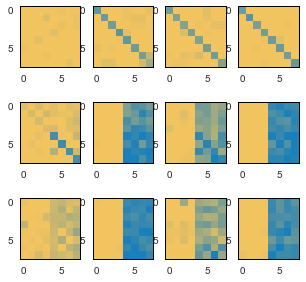

In [17]:

    
    #plt.colorbar()

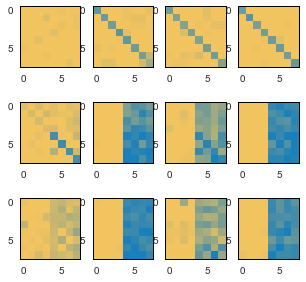

In [18]:
#Behavior only (load behave_dict and plot corct ratios)
df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<40)]

#initialize df with scores per session
df_rats = pd.DataFrame()
#initialize df for analyis_table for all rats and sessions
Big_Analysis_table_mode=pd.DataFrame()

for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']

        filtered_dict = {k: v for k, v in behave_dict.items() if k != 'Analysis_table_mod'}
        filtered_dict['rats']=session_name[:4]
        filtered_dict['session_name'] = session_name
        filtered_dict['session_title'] = session_title
        filtered_dict['session_id'] = index
        df = pd.DataFrame([filtered_dict])
        if df_rats.empty:
            df_rats = pd.DataFrame(columns=df.columns)
        df_rats = pd.concat([df_rats,df ], axis=0)

        Analysis_table_f = behave_dict['Analysis_table_mod']
        Analysis_table_f['rats'] = session_name[:4]
        Analysis_table_f['session_name'] = session_name
        Analysis_table_f['session_title'] = session_title
        Analysis_table_f['session_id'] = index

        if Big_Analysis_table_mode.empty:
            Big_Analysis_table_mode = pd.DataFrame(columns=Analysis_table_f.columns)
        Big_Analysis_table_mode = pd.concat([Big_Analysis_table_mode,Analysis_table_f], axis=0)
df_rats['bin_column'] = df_rats['session_id'].apply(categorize_into_bins)

#Figure 2a-c
import matplotlib.colors as mcolors

colors = ["#1a80bb", "#f2c45f"]  # Blue to orange shades
num_colors = 100  # Control the number of colors in the transition
blue_to_orange = mcolors.LinearSegmentedColormap.from_list("BlueToOrange", colors, N=num_colors)
#fig, ax = plt.subplots(figsize=(1.6, 1.6))
fig, axes = plt.subplots(3,4,figsize=(5, 5))

l = [0, 4, 5, 9, 15, 19, 20, 24, 30,34,35,39]
odor_means =Big_Analysis_table_mode.groupby(['session_id','odor_before','odor_ID']).go_nogo.mean()
axes = axes.flatten()

for i, value in enumerate(l):
    go_odors_mat = odor_means.loc[(value, slice(None), slice(None))].unstack().values # select the session #
    axes[i].imshow(go_odors_mat, cmap = blue_to_orange, interpolation='nearest',vmin=0, vmax=1)


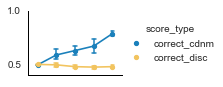

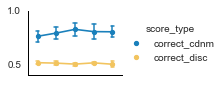

In [19]:
# Learning curves Figure 2d
df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')


color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#f2c45f","#f2c45f","#eddca5"]

for i in range(1, 3):
    data = melted_df[(melted_df.bin_column==i) ]

    g = sns.catplot(data=data, x="session_id", y="score_value", hue="score_type",capsize=.2, palette=color_set,
                    kind="point", height=1.6, aspect=1.45,estimator=np.mean,linestyles=["-", "-"],
                    linewidth=1,  # Line width
                    markers=["o", "o"],  # Marker shapes
                    errwidth=1.5,  # Width of error bars
                    scatter_kws={"s": 10},scale=.6)  # Marker size)
    g.set_titles(""); g.despine(left=False,bottom=False,top=True)
    g.set(ylabel='',xlabel='',xticks = [],title = '',yticks = [.5,1], ylim=(.4, 1))
    plt.show()

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_57420/2991632584.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['session_id'] = data['session_id'].apply(lambda x: x - 15 if x >= 30 else x)
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_57420/2991632584.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['combined'] = data['score_type'] + ' - Bin ' + data['bin_column'].astype(str)


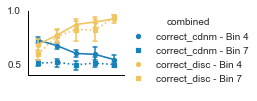

                               sum_sq    df          F        PR(>F)
C(session_id)                0.049723   4.0   5.893966  1.268044e-03
C(bin_column)                0.144942   1.0  68.723701  2.972822e-09
C(session_id):C(bin_column)  0.035195   4.0   4.171956  8.362281e-03
Residual                     0.063271  30.0        NaN           NaN
Post-hoc results for 15:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     4      7  -0.2153 0.001 -0.2756 -0.155   True
--------------------------------------------------
Post-hoc results for 16:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      7  -0.1548 0.0016 -0.2244 -0.0853   True
----------------------------------------------------
Post-hoc results for 17:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 

/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_57420/2991632584.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['session_id'] = data['session_id'].apply(lambda x: x - 15 if x >= 30 else x)
/var/folders/4m/5b48_0dx7q39sr9sc25bzw1hkhncj1/T/ipykernel_57420/2991632584.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['combined'] = data['score_type'] + ' - Bin ' + data['bin_column'].astype(str)


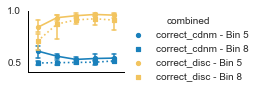

                               sum_sq    df          F    PR(>F)
C(session_id)                0.006541   4.0   1.515011  0.225798
C(bin_column)                0.027945   1.0  25.890370  0.000024
C(session_id):C(bin_column)  0.010971   4.0   2.541200  0.062809
Residual                     0.029142  27.0        NaN       NaN
Post-hoc results for 20:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      8  -0.1161 0.0115 -0.1952 -0.0369   True
----------------------------------------------------
Post-hoc results for 21:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     5      8  -0.0631 0.0122 -0.1054 -0.0208   True
----------------------------------------------------
Post-hoc results for 22:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 mean

In [9]:
# Learning curves exp+control combined Figure 2g
df_rats['bias']=(df_rats['correct_cdnm']-df_rats['correct_disc'])/(df_rats['correct_disc']+df_rats['correct_cdnm'])
df_reset = df_rats.reset_index(drop=True)


melted_df = pd.melt(df_reset, id_vars=[ 'rats','session_id','bin_column'], value_vars=['correct_cdnm','correct_disc'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#1a80bb","#f2c45f","#f2c45f"]

for i in range(4, 6): 
    data = melted_df[((melted_df.bin_column==i) | (melted_df.bin_column==i+3)) ]
    
    data['session_id'] = data['session_id'].apply(lambda x: x - 15 if x >= 30 else x)
    data['combined'] = data['score_type'] + ' - Bin ' + data['bin_column'].astype(str)
    
    g = sns.catplot(data=data, x="session_id", y="score_value", hue="combined", dashes = "bin_column",capsize=.2, palette=color_set,
                    kind="point", height=1.6, aspect=1.53,estimator=np.mean,linestyles=["-", ":","-", ":"],
                    linewidth=1,  # Line width
                    markers=["o", "s","o", "s"],  # Marker shapes
                    errwidth=1.5,  # Width of error bars
                    scatter_kws={"s": 10},scale=.6)  # Marker size)
    g.set_titles(""); g.despine(left=False,bottom=False,top=True);
    g.set(ylabel='',xlabel='',xticks = [],title = '',yticks = [.5,1], ylim=(.4, 1))
    plt.show()
    g.savefig(f'{save_path}/LC4.png', dpi=300, bbox_inches='tight')
    # Performing the two-way ANOVA with interaction
    data_cdnm=data[data['score_type']=='correct_cdnm']
    #data_cdnm=data[data['score_type']=='correct_disc']
    from statsmodels.formula.api import ols
    
    model = ols('score_value ~ C(session_id) * C(bin_column)', data=data_cdnm).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(anova_table)
    
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    # Perform pairwise comparisons within each level of factor1
    for level in data_cdnm['session_id'].unique():
        subset = data_cdnm[data_cdnm['session_id'] == level]
    
        tukey = pairwise_tukeyhsd(endog=subset['score_value'], groups=subset['bin_column'], alpha=0.05)
        print(f"Post-hoc results for {level}:")
        print(tukey)                            

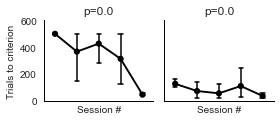

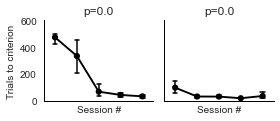

In [20]:
# Trials to criterion. Figure 2 e-h
from scipy.stats import kendalltau

crit_df=pd.DataFrame(columns=['session_id','rats','tr_to_crit'])
index=[]
i=-1
for  (group, df) in Big_Analysis_table_mode.groupby(['session_id','rats'], group_keys=True,sort=False):#to ensure the order of the groups as the original
    i=i+1
    crit_df.loc[i,'session_id']=group[0]
    crit_df.loc[i,'rats']=group[1]
    crit_df.loc[i,'tr_to_crit']=find_first_index(df.reset_index())

crit_df['bin_column'] = crit_df['session_id'].apply(categorize_into_bins)


data = crit_df[(crit_df['session_id']>=0)&(crit_df['session_id']<10) ]

LC = sns.catplot(
    data=data, x="session_id", y="tr_to_crit", col = "bin_column",
    capsize=.2, color='black', errorbar="se",sharex=False,
    kind="point", height=2, aspect=1,scale=0.7, linewidth=1, errwidth=1.5)
LC.despine(left=False,bottom=False,top=True)
#g.refline(y=0.5,linestyle=":")
result = data.groupby(['bin_column','session_id','rats']).agg({'tr_to_crit': 'mean'})

values=result['tr_to_crit']
tau, p_value = kendalltau(values.index, values)
LC.set(ylabel='Trials to criterion',ylim = (0,600), xlabel='Session #',xticks = [],title = f'p={round(p_value,5)}')


plt.show()
LC.savefig("Trials to criterion1.png", dpi=300, bbox_inches='tight')
data = crit_df[(crit_df['session_id']>=15)&(crit_df['session_id']<25) ]

LC = sns.catplot(
    data=data, x="session_id", y="tr_to_crit", col = "bin_column",
    capsize=.2, color='black', errorbar="se",sharex=False,
    kind="point", height=2, aspect=1,scale=0.7, linewidth=1, errwidth=1.5)
LC.despine(left=False,bottom=False,top=True)
#g.refline(y=0.5,linestyle=":")
result = data.groupby(['bin_column','session_id','rats']).agg({'tr_to_crit': 'mean'})

values=result['tr_to_crit']
tau, p_value = kendalltau(values.index, values)
LC.set(ylabel='Trials to criterion',ylim = (0,600), xlabel='Session #',xticks = [],title = f'p={round(p_value,5)}')


plt.show()

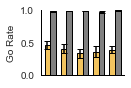

                              sum_sq    df           F        PR(>F)
C(session_id)               0.019507   4.0    0.520465  7.213347e-01
C(Condition)                3.514516   1.0  375.090489  1.655495e-18
C(session_id):C(Condition)  0.017818   4.0    0.475408  7.534197e-01
Residual                    0.281093  30.0         NaN           NaN
Post-hoc results for 5:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1              group2       meandiff p-adj lower  upper  reject
---------------------------------------------------------------------------
FaRate_disc0_cdnm0P FaRate_disc0_cdnm1P   0.5211 0.001 0.3685 0.6738   True
---------------------------------------------------------------------------
Post-hoc results for 6:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1              group2       meandiff p-adj lower  upper reject
--------------------------------------------------------------------------
Fa

In [22]:
#Go probability figure 2f
from scipy import stats

df_sessions_f = df_sessions[(df_sessions.index>=0)&(df_sessions.index<5)]
df_sessions_f = df_sessions[(df_sessions.index>=5)&(df_sessions.index<10)]
color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

fig, ax = plt.subplots(figsize=(1.5, 1.2))
#fig, ax = plt.subplots(figsize=(5, 5))

bar1 = ax.bar(x - width/2, grouped_df['mean_missrate_0'], width, yerr=grouped_df['sem_missrate_0'], label='MissRate_disc1_cdnm0P', capsize=3,facecolor=color_set[1], edgecolor='black')
bar2 = ax.bar(x + width/2, grouped_df['mean_missrate_1'], width, yerr=grouped_df['sem_missrate_1'], label='MissRate_disc1_cdnm1P', capsize=3,facecolor='gray', edgecolor='black')

ax.set_xlabel('')
ax.set_ylabel('Go Rate')
ax.set_xticks(x)
ax.set_xticklabels('')
#ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines["left"].set_visible(True)  # Ensure left spine is visible

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(ylim=(0,1))
ax.tick_params(axis="y", which="both", length=3, width=1)  # Adjust tick length/width

plt.savefig("GO_cdnma.png", dpi=300, bbox_inches='tight')

plt.show()

# Statistical comparison between MissRate_disc1_cdnm0P and MissRate_disc1_cdnm1P
missrate_0 = df_behave_bins['FaRate_disc0_cdnm0P']
missrate_1 = df_behave_bins['FaRate_disc0_cdnm1P']

# Perform a paired t-test
t_stat, p_val = stats.ttest_rel(missrate_0, missrate_1)

# Prepare data in long format for the ANOVA
anova_data_long = df_behave_bins.melt(id_vars=['rats', 'session_id'], value_vars=['FaRate_disc0_cdnm0P', 'FaRate_disc0_cdnm1P'],
                                      var_name='Condition', value_name='FARate')

# Performing the two-way ANOVA with interaction
model = ols('FARate ~ C(session_id) * C(Condition)', data=anova_data_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform pairwise comparisons within each level of factor1
for level in anova_data_long['session_id'].unique():
    subset = anova_data_long[anova_data_long['session_id'] == level]

    tukey = pairwise_tukeyhsd(endog=subset['FARate'], groups=subset['Condition'], alpha=0.05)
    print(f"Post-hoc results for {level}:")
    print(tukey)

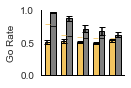

In [23]:
# go prob bars but with control figure 2i
df_sessions_f = df_sessions[(df_sessions.index>=15)&(df_sessions.index<20)]
#df_sessions_f = df_sessions[(df_sessions.index>=20)&(df_sessions.index<25)]

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

fig, ax = plt.subplots(figsize=(1.5, 1.2))
#fig, ax = plt.subplots(figsize=(5, 5))

bar1 = ax.bar(x - width/2, grouped_df['mean_missrate_0'], width, yerr=grouped_df['sem_missrate_0'], label='MissRate_disc1_cdnm0P', capsize=3,facecolor=color_set[1], edgecolor='black')
bar2 = ax.bar(x + width/2, grouped_df['mean_missrate_1'], width, yerr=grouped_df['sem_missrate_1'], label='MissRate_disc1_cdnm1P', capsize=3,facecolor='gray', edgecolor='black')


df_sessions_f = df_sessions[(df_sessions.index>=35)&(df_sessions.index<40)]
color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]

#initialize df with scores per session
df_behave_bins_temp = []
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        y = np.array(Analysis_table_f.go_nogo)
        s1 = np.column_stack((Analysis_table_f.odor_ID,Analysis_table_f.odor_ID.shift(1,fill_value=np.nan),Analysis_table_f.odor_ID.shift(2,fill_value=np.nan)))
        cdnm_rule = s1[:,0]!=s1[:,1]
        disc_rule = np.in1d(s1[:,0], [0,1,2,3,4,5,6,7])


        MissRate_disc1_cdnm0 =(y[(cdnm_rule==0) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm0P=np.average(MissRate_disc1_cdnm0)
        MissRate_disc1_cdnm1 =(y[(cdnm_rule==1) & (disc_rule==1)].astype(bool)==0)
        MissRate_disc1_cdnm1P=np.average(MissRate_disc1_cdnm1)
        FaRate_disc0_cdnm0 = (y[(cdnm_rule==0) ].astype(bool)==1)
        FaRate_disc0_cdnm0P=np.average(FaRate_disc0_cdnm0)
        FaRate_disc0_cdnm1 = (y[(cdnm_rule==1) ].astype(bool)==1)
        FaRate_disc0_cdnm1P=np.average(FaRate_disc0_cdnm1)
        df_behave_bins_temp.append({'MissRate_disc1_cdnm0P':MissRate_disc1_cdnm0P,
                                    'MissRate_disc1_cdnm1P':MissRate_disc1_cdnm1P,
                                    'FaRate_disc0_cdnm0P':FaRate_disc0_cdnm0P,
                                    'FaRate_disc0_cdnm1P':FaRate_disc0_cdnm1P,
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)

# Group by session_id and calculate mean and SEM
grouped_df = df_behave_bins.groupby('session_id').agg(
    mean_missrate_0=('FaRate_disc0_cdnm0P', 'mean'),
    sem_missrate_0=('FaRate_disc0_cdnm0P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    mean_missrate_1=('FaRate_disc0_cdnm1P', 'mean'),
    sem_missrate_1=('FaRate_disc0_cdnm1P', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Plotting the grouped bar chart
x = np.arange(len(grouped_df['session_id']))
width = 0.35

line_width=.8
line_length = 0.16
for X, mean in zip(x - width/2,grouped_df['mean_missrate_0']):
    ax.hlines(y=mean, xmin=X - line_length, xmax=X + line_length, colors=color_set[1], linewidth=line_width,linestyle='-')
for X, mean in zip(x + width/2,grouped_df['mean_missrate_1']):
    ax.hlines(y=mean, xmin=X - line_length, xmax=X + line_length, colors='k', linewidth=line_width,linestyle='-')


ax.set_xlabel('')
ax.set_ylabel('Go Rate')
ax.set_xticks(x)
ax.set_xticklabels('')
#ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines["left"].set_visible(True)  # Ensure left spine is visible

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set(ylim=(0,1))
ax.tick_params(axis="y", which="both", length=3, width=1)  # Adjust tick length/width
plt.show()


In [ ]:
#Learning curves with multiple bins per session Supplementary figure1
df_sessions_f = df_sessions[(df_sessions.index >= 0) & (df_sessions.index < 40) & ~df_sessions.index.isin(range(25, 30))]

#initialize df with scores per session
df_behave_bins_temp = []
bin_num=5
for index, row in df_sessions_f.iterrows():
    session_title = row['session_title']
    session_names = row['session_names']
    for (session_idx, session_name) in enumerate(session_names):
        with open(f'{save_path}/all_data_{session_name}.pkl', 'rb') as f:
            loaded_data = pickle.load(f)
        behave_dict=loaded_data['behave_dict']


        Analysis_table_f = behave_dict['Analysis_table_mod']
        correct_cdnm_bin,correct_disc_bin,dPrime_cdnm_bin,dPrime_disc_bin,HitRate_cdnm_bin,FARate_cdnm_bin,HitRate_disc_bin,FARate_disc_bin,correct_cdnm_only_bin,correct_disc_only_bin = bin_performance(Analysis_table_f,  bin_num=bin_num)
        df_behave_bins_temp.append({'correct_cdnm_bin':correct_cdnm_bin,
                                    'correct_disc_bin':correct_disc_bin,
                                    'dPrime_cdnm_bin':dPrime_cdnm_bin,
                                    'dPrime_disc_bin':dPrime_disc_bin,
                                    'HitRate_cdnm_bin':HitRate_cdnm_bin,
                                    'FARate_cdnm_bin':FARate_cdnm_bin,
                                    'HitRate_disc_bin':HitRate_disc_bin,
                                    'FARate_disc_bin':FARate_disc_bin,
                                    'correct_cdnm_only_bin':correct_cdnm_only_bin,
                                    'correct_disc_only_bin':correct_disc_only_bin,
                                    'bin_id':range(bin_num),
                                    'rats':session_name[:4],
                                    'session_name':session_name,
                                    'session_title':session_title,
                                    'session_id':index})
df_behave_bins=pd.DataFrame(df_behave_bins_temp)
df_behave_bins
df_behave_bins_exploded = df_behave_bins.explode(['correct_cdnm_bin','correct_disc_bin','dPrime_cdnm_bin','dPrime_disc_bin','HitRate_cdnm_bin','FARate_cdnm_bin',
                                                  'HitRate_disc_bin','FARate_disc_bin','correct_cdnm_only_bin','correct_disc_only_bin','bin_id'])
df_behave_bins_exploded
data = pd.melt(df_behave_bins_exploded, id_vars=[ 'rats','session_id','bin_id'], value_vars=['correct_cdnm_bin','correct_disc_bin'], var_name='score_type', value_name='score_value')

color_set = ["#1a80bb", "#f2c45f", "#b8b8b8", "#FF33FF", "#FFFF33"]
LC = sns.catplot(data=data, x="bin_id", y="score_value", palette=color_set,
                 errorbar="se",sharex=False,col = "session_id",hue='score_type',col_wrap=5,
                 kind="point", height=2, aspect=.85)
LC.despine(left=False,bottom=False,top=True)
LC.refline(y=.5,linestyle=":")
LC.set(ylim=(.4,1),ylabel='',xlabel='',xticks = [],yticks=[.5, 1],title = '')

plt.show()